In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy.stats import ttest_ind
import math
from scipy.stats import pearsonr, spearmanr
import plotly.graph_objects as go
import plotly.express as px
from sklearn.impute import SimpleImputer, KNNImputer
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
import pickle
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression

In [3]:
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [4]:
pd.options.display.max_columns = 50
seed = 42

# functions

In [152]:
def run_corr_pancancer(drug_id, data_sample, ic50, key='logFC_norm'):
    res_df = []
    tmp_df = ic50[ic50['Drug Id'] == drug_id].sort_values(
        by=['Cell line name']).reset_index(drop=True)
    cell_line_drug = tmp_df['Cell line name'].values
    protein_drug = data_sample[data_sample['Cell_line'].isin(cell_line_drug)]
    ic50_drug = tmp_df[tmp_df['Cell line name'].isin(
        protein_drug['Cell_line'])][key].values

    for protein in protein_drug.columns:
        if protein == 'Cell_line':
            continue
        protein_drug_tissue_protein = protein_drug[protein].values
        ic50_drug_tissue_protein = ic50_drug
        ic50_drug_tissue_protein = ic50_drug_tissue_protein[
            ~np.isnan(protein_drug_tissue_protein)]
        protein_drug_tissue_protein = protein_drug_tissue_protein[
            ~np.isnan(protein_drug_tissue_protein)]
        if protein_drug_tissue_protein.size <= 2:
            continue
        p_corr, p_pval = pearsonr(protein_drug_tissue_protein,
                                  ic50_drug_tissue_protein)
#         s_corr, s_pval = spearmanr(protein_drug_tissue_protein,
#                                    ic50_drug_tissue_protein)
        res_df.append({
            'Drug name': drug_id,
            'protein': protein,
            'pearson_correlation': p_corr,
            'pearson_pval': p_pval,
#             'spearman_correlation': s_corr,
#             'spearman_pval': s_pval,
            'count': protein_drug_tissue_protein.size
        })
    res_df = pd.DataFrame(res_df)
    return res_df

In [125]:
def run_corr_pancancer_sanger(drug_id, data_sample, ic50):
    res_df = []
    tmp_df = ic50[ic50['Drug Id'] == drug_id].sort_values(
        by=['Cell line name']).reset_index(drop=True)
    cell_line_drug = tmp_df['Cell line name'].values
    protein_drug = data_sample[data_sample['Cell_line'].isin(cell_line_drug)]
    ic50_drug = tmp_df[tmp_df['Cell line name'].isin(
        protein_drug['Cell_line'])]['IC50_norm_scaled'].values

    for protein in protein_drug.columns:
        if protein == 'Cell_line':
            continue
        protein_drug_tissue_protein = protein_drug[protein].values
        ic50_drug_tissue_protein = ic50_drug
        ic50_drug_tissue_protein = ic50_drug_tissue_protein[
            ~np.isnan(protein_drug_tissue_protein)]
        protein_drug_tissue_protein = protein_drug_tissue_protein[
            ~np.isnan(protein_drug_tissue_protein)]
        if protein_drug_tissue_protein.size <= 2:
            continue
        p_corr, p_pval = pearsonr(protein_drug_tissue_protein,
                                  ic50_drug_tissue_protein)
#         s_corr, s_pval = spearmanr(protein_drug_tissue_protein,
#                                    ic50_drug_tissue_protein)
        res_df.append({
            'Drug Id': drug_id,
            'protein': protein,
            'pearson_correlation': p_corr,
            'pearson_pval': p_pval,
#             'spearman_correlation': s_corr,
#             'spearman_pval': s_pval,
            'count': protein_drug_tissue_protein.size
        })
    res_df = pd.DataFrame(res_df)
    return res_df

In [43]:
def run_corr(drug_name, data_sample, ic50):
    res_df = []
    tmp_df = ic50[ic50['Drug name'] == drug_name].sort_values(
        by=['Cell line name']).reset_index(drop=True)
    cell_line_drug = tmp_df['Cell line name'].values
    gene_drug = data_sample[data_sample['Cell_line'].isin(cell_line_drug)]
    ic50_drug = tmp_df[tmp_df['Cell line name'].isin(gene_drug['Cell_line'])]
    for tissue, cell_lines in tissue_cell_line.items():
        gene_drug_tissue = gene_drug[gene_drug['Cell_line'].isin(cell_lines)]
        ic50_drug_tissue = ic50_drug[ic50_drug['Cell line name'].isin(
            cell_lines)]
        for gene in gene_drug.columns:
            if gene == 'Cell_line':
                continue
            gene_drug_tissue_gene = gene_drug_tissue[gene].values
            ic50_drug_tissue_gene = ic50_drug_tissue['logFC_norm'].values
            if gene_drug_tissue_gene.size <= 2:
                continue
            # TODO filter out nan
            ic50_drug_tissue_gene = ic50_drug_tissue_gene[
                ~np.isnan(gene_drug_tissue_gene)]
            gene_drug_tissue_gene = gene_drug_tissue_gene[
                ~np.isnan(gene_drug_tissue_gene)]
            p_corr, p_pval = pearsonr(gene_drug_tissue_gene,
                                      ic50_drug_tissue_gene)
#             s_corr, s_pval = spearmanr(gene_drug_tissue_gene,
#                                        ic50_drug_tissue_gene)
            res_df.append({
                'Drug name': drug_name,
                'gene': gene,
                'tissue': tissue,
                'pearson_correlation': p_corr,
                'pearson_pval': p_pval,
#                 'spearman_correlation': s_corr,
#                 'spearman_pval': s_pval,
                'count': gene_drug_tissue_gene.size
            })
    res_df = pd.DataFrame(res_df)
    return res_df

In [7]:
def heatmap(protein, sample_data):
    res_all_filtered_protein = res_all_filtered[res_all_filtered['protein']==protein]
    res_df_filtered_protein = res_df_filtered[res_df_filtered['protein']==protein]

    tmp_df = pd.pivot(res_all_filtered_protein.groupby(
        ['tissue',
         'Drug Id'])['pearson_correlation'].mean().sort_values().reset_index(),
                      index='Drug Id',
                      columns='tissue')
    tmp_df.columns = [
        x[1].replace('pearson_correlation-', '') for x in tmp_df.columns
    ]
    tmp_df = tmp_df.dropna()
    g = sns.clustermap(
        tmp_df,
        cmap='coolwarm',
        figsize=(12, 12),
        cbar_pos=(0.02, 0.85, 0.05, 0.12),
        vmin=-1,
        vmax=1,
        row_colors=tmp_df.index.map(target_pathway_dict).map(target_pathway_color))
    l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.05,0.12),handles=legend_TN,frameon=True)

    protein = protein.replace('_HUMAN', '')
    g.fig.suptitle(f'Correlation {protein}/IC50')
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.show()

In [8]:
def heatmap_drug_one(protein, drug_id):
    res_all_filtered_protein = res_all_filtered[res_all_filtered['protein']==protein]
    res_df_filtered_protein = res_df_filtered[res_df_filtered['protein']==protein]
    res_all_filtered_protein_drug = res_all_filtered_protein[
    res_all_filtered_protein['Drug Id'] == drug]
    tmp_df = pd.pivot(res_all_filtered_protein_drug.groupby(
        ['tissue',
         'Drug Id'])['pearson_correlation'].mean().sort_values().reset_index(),
                      index='Drug Id',
                      columns='tissue')
    tmp_df.columns = [
        x[1].replace('pearson_correlation-', '') for x in tmp_df.columns
    ]
    tmp_df.index = [f'{tmp_df.index.values[0]} - {drug_name_map[tmp_df.index[0]]}']
    g = sns.clustermap(tmp_df,
                       cmap='coolwarm',
                       figsize=(16, 2),
                       cbar_pos=(0.3, 0.85, 0.01, 0.3),
                       vmin=-1,
                       vmax=1,
                       row_cluster=False,
                       annot=True,
                       fmt='.2f')
    protein = protein.replace('_HUMAN', '')
    g.fig.suptitle(f'Correlation {protein}/IC50')
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, va='center')

    plt.show()

In [9]:
def drug_scatter_all(protein):
    protein_map = protein_sample.set_index('Cell_line').to_dict()[protein]

    tmp_ic50 = ic50[['Drug Id', 'Cell line name', 'IC50','Tissue_type']]

    tmp_ic50 = tmp_ic50[tmp_ic50['Drug Id'].isin(drug_list)]

    tmp_ic50['protein_abundance'] = tmp_ic50['Cell line name'].map(protein_map)

    plt.figure(figsize=(12,10))
    tmp_ic50 = tmp_ic50.dropna()
    r, pval = pearsonr(tmp_ic50['protein_abundance'], tmp_ic50['IC50'])
    tmp_ic50 = tmp_ic50.sample(frac=0.01)
    sns.scatterplot(x='protein_abundance', y='IC50', hue='Tissue_type', data=tmp_ic50)
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.text(tmp_ic50['protein_abundance'].min()*0.9, tmp_ic50['IC50'].max()*0.9, f'R={r:.4f}, pval={pval:.4e}')

In [12]:
def drug_scatter_one(gene, drug, sample_data, ic50, x=0.8, y=0.8):
    gene_map = sample_data.set_index('Cell_line').to_dict()[f'{gene}']

    tmp_ic50 = ic50[['Drug Id', 'Cell line name', 'IC50', 'Tissue_type']]

    tmp_ic50['gene_abundance'] = tmp_ic50['Cell line name'].map(gene_map)
    tmp_ic50 = tmp_ic50[tmp_ic50['Drug Id'] == drug]
    tmp_ic50 = tmp_ic50.dropna()
    tmp_ic50 = tmp_ic50[tmp_ic50['Cell line name'].isin(common_cell_lines)]
    num_points = tmp_ic50['Cell line name'].unique().size

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    sns.scatterplot(x='gene_abundance',
                    y='IC50',
                    hue='Tissue_type',
                    hue_order=sorted(tmp_ic50['Tissue_type'].unique()),
                    data=tmp_ic50,
                    linewidth=0.1,
                    edgecolor='b',
                    alpha=0.9)
    reg = LinearRegression()
    reg.fit(tmp_ic50['gene_abundance'].values.reshape(-1, 1), tmp_ic50['IC50'])
    y_pred = reg.predict(tmp_ic50['gene_abundance'].values.reshape(-1, 1))
    plt.plot(tmp_ic50['gene_abundance'], y_pred, color='red')
    r, pval = pearsonr(tmp_ic50['gene_abundance'], tmp_ic50['IC50'])
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

    plt.text(x,
             y,
             f'R={r:.4f}, pval={pval:.2e}',
             ha='center',
             va='center',
             transform=ax.transAxes,
             fontdict={'size': 12})
    plt.title(
        f"{gene}/IC50 for Drug Id {drug} - {drug_name_map[drug]} (n={num_points})"
    )
    plt.xlabel(f"{gene} abundance")

In [13]:
def drug_scatter_one_tissue(gene,
                            drug,
                            sample_data,
                            tissue_list,
                            ic50,
                            x=0.8,
                            y=0.8):
    gene_map = sample_data.set_index('Cell_line').to_dict()[f'{gene}']

    tmp_ic50 = ic50[['Drug Id', 'Cell line name', 'IC50', 'Tissue_type']]

    tmp_ic50['gene_abundance'] = tmp_ic50['Cell line name'].map(gene_map)
    tmp_ic50 = tmp_ic50[tmp_ic50['Drug Id'] == drug]
    tmp_ic50 = tmp_ic50.dropna()
    tmp_ic50 = tmp_ic50[(tmp_ic50['Drug Id'] == drug)
                        & (tmp_ic50['Tissue_type'].isin(tissue_list))]
    num_points = tmp_ic50['Cell line name'].unique().size

    r, pval = pearsonr(tmp_ic50['gene_abundance'], tmp_ic50['IC50'])
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    sns.scatterplot(x='gene_abundance',
                    y='IC50',
                    hue='Tissue_type',
                    data=tmp_ic50)
    reg = LinearRegression()
    reg.fit(tmp_ic50['gene_abundance'].values.reshape(-1, 1), tmp_ic50['IC50'])
    y_pred = reg.predict(tmp_ic50['gene_abundance'].values.reshape(-1, 1))
    plt.plot(tmp_ic50['gene_abundance'], y_pred, color='red')
    plt.text(x,
             y,
             f'R={r:.4f}, pval={pval:.2e}',
             ha='center',
             va='center',
             transform=ax.transAxes,
             fontdict={'size': 12})
    plt.xlabel(f"{gene} abundance")
    plt.title(f"{gene}/IC50 for Drug Id {drug} - {drug_name_map[drug]} (n={num_points})")

In [14]:
def rna_protein_scatter(gene, protein, rna_data, protein_data, ic50, x=0.8, y=0.8, drug=None):
    rna_map = rna_data.set_index('Cell_line').to_dict()[f'{gene}']
    protein_map = protein_data.set_index('Cell_line').to_dict()[f'{protein}']

    tmp_ic50 = ic50[['Drug Id', 'Cell line name', 'IC50', 'Tissue_type']]

    tmp_ic50['gene_expression'] = tmp_ic50['Cell line name'].map(rna_map)
    tmp_ic50['protein_abundance'] = tmp_ic50['Cell line name'].map(protein_map)

    if drug:
        tmp_ic50 = tmp_ic50[tmp_ic50['Drug Id'] == drug]
    tmp_ic50 = tmp_ic50.dropna()
    tmp_ic50 = tmp_ic50[tmp_ic50['Cell line name'].isin(common_cell_lines)]
    tmp_ic50 = tmp_ic50.drop_duplicates('Cell line name')
    num_points = tmp_ic50['Cell line name'].unique().size

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    sns.scatterplot(x='gene_expression',
                    y='protein_abundance',
                    hue='Tissue_type',
                    hue_order=sorted(tmp_ic50['Tissue_type'].unique()),
                    data=tmp_ic50,
                    linewidth=0.1,
                    edgecolor='b',
                    alpha=0.9)
    reg = LinearRegression()
    reg.fit(tmp_ic50['gene_expression'].values.reshape(-1, 1), tmp_ic50['protein_abundance'])
    y_pred = reg.predict(tmp_ic50['gene_expression'].values.reshape(-1, 1))
    plt.plot(tmp_ic50['gene_expression'], y_pred, color='red')
    r, pval = pearsonr(tmp_ic50['gene_expression'], tmp_ic50['protein_abundance'])
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

    plt.text(x,
             y,
             f'R={r:.4f}, pval={pval:.2e}',
             ha='center',
             va='center',
             transform=ax.transAxes,
             fontdict={'size': 12})
    plt.title(
        f"{gene}/{protein} correlation (n={num_points})"
    )

# compute

In [121]:
drug_score = pd.read_csv("../data/drug/202004092336_drug_scores.tsv", sep="\t")
drug_list = drug_score[
    (drug_score['MultiDrug_correlation'] > 0.4) & (drug_score['sensitive_count'] > 20)][
    'DRUG_NAME'].values
drug_list = [x.lower() for x in drug_list]

In [153]:
ccle_drug = pd.read_csv("../data/ccle/drug_all_ccle_secondary_processed_10.csv")

In [123]:
sanger_drug = pd.read_csv("../data/drug/ic50_processed.csv")

In [62]:
ccle_protein = pd.read_csv(
    "../data/ccle/protein_matrix_common.tsv",
    sep='\t').sort_values(by='Cell_line').reset_index(drop=True)

In [63]:
sanger_protein = pd.read_csv(
    "../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control.txt",
    sep='\t').sort_values(by='Cell_line').reset_index(drop=True)

In [154]:
selected_drugs = ccle_drug['Drug Id'].unique()

In [146]:
selected_drugs_sanger = sanger_drug['Drug Id'].unique()

In [156]:
res_pancancer = Parallel(n_jobs=16)(delayed(run_corr_pancancer)(drug_name, ccle_protein, ccle_drug, 'logFC')
                          for drug_name in tqdm_notebook(selected_drugs))
res_pancancer_all = pd.concat(res_pancancer).sort_values(by=['pearson_pval'])

<ipython-input-156-5250582fe783>:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [55]:
res_pancancer_sanger_drug = Parallel(n_jobs=16)(delayed(run_corr_pancancer_sanger)(drug_name, ccle_protein, sanger_drug)
                          for drug_name in tqdm_notebook(selected_drugs_sanger))
res_pancancer_sanger_drug_all = pd.concat(res_pancancer_sanger_drug).sort_values(by=['pearson_pval'])

<ipython-input-55-c928f6f1579e>:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [136]:
pickle.dump(res_pancancer_all, open("../data/ccle/res_pancancer_all_correlation_secondary_auc.pkl", "wb"))

# load data

In [73]:
res_pancancer_all = pickle.load(open("../data/ccle/res_pancancer_all_correlation.pkl", "rb"))

In [137]:
res_pancancer_all_secondary = pickle.load(open("../data/ccle/res_pancancer_all_correlation_secondary_auc.pkl", "rb"))

# CCLE primary vs secondary

In [116]:
ccle_primary = pd.read_csv("../data/ccle/drug_all_ccel_processed.csv")
ccle_secondary = pd.read_csv("../data/ccle/drug_all_ccle_secondary_processed_10.csv")

In [117]:
ccle_combined = pd.merge(ccle_primary,
                         ccle_secondary,
                         on=['Cell line name', 'Drug name'],
                         suffixes=['_primary', '_secondary'])

In [118]:
print(ccle_primary.shape)
print(ccle_secondary.shape)
print(ccle_combined.shape)

(1012778, 5)
(249203, 5)
(244807, 8)


In [119]:
pearsonr(ccle_combined['logFC_primary'].values, ccle_combined['logFC_secondary'].values)

(0.5263633497165018, 0.0)

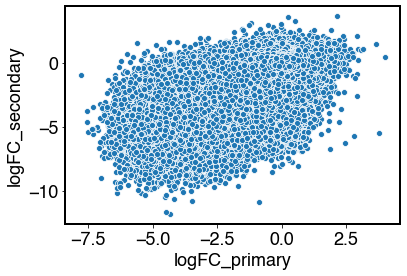

In [97]:
sns.scatterplot(x='logFC_primary', y='logFC_secondary', data=ccle_combined)

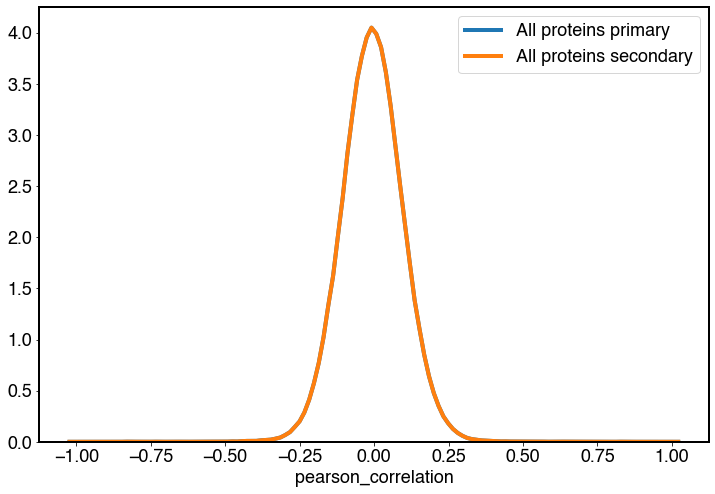

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
sns.distplot(res_pancancer_all['pearson_correlation'],
             label='All proteins primary',
             hist=False,
             kde_kws=dict(linewidth=4))
sns.distplot(res_pancancer_all_secondary['pearson_correlation'],
             label='All proteins secondary',
             hist=False,
             kde_kws=dict(linewidth=4))

# CCLE protein, Broad drug

In [157]:
res_pancancer_all_common = res_pancancer_all[
    res_pancancer_all['Drug name'].isin(drug_list)].reset_index(drop=True)

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [159]:
res_pancancer_all_common = res_pancancer_all

(-0.7, 0.7)

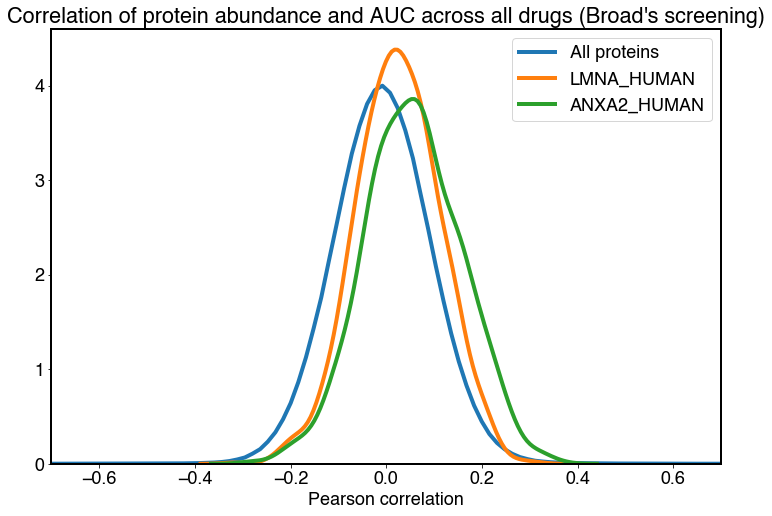

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
plt.title("Correlation of protein abundance and AUC across all drugs (Broad's screening)")
sns.distplot(res_pancancer_all_common['pearson_correlation'], label='All proteins', hist=False, kde_kws=dict(linewidth=4))
sns.distplot(res_pancancer_all_common[res_pancancer_all_common['protein'] ==
                                      "LMNA_HUMAN"]['pearson_correlation'], label='LMNA_HUMAN', hist=False, kde_kws=dict(linewidth=4))
sns.distplot(res_pancancer_all_common[res_pancancer_all_common['protein'] ==
                                      "ANXA2_HUMAN"]['pearson_correlation'], label='ANXA2_HUMAN', hist=False, kde_kws=dict(linewidth=4))
plt.xlabel("Pearson correlation")
plt.xlim(-0.7, 0.7)

(-0.7, 0.7)

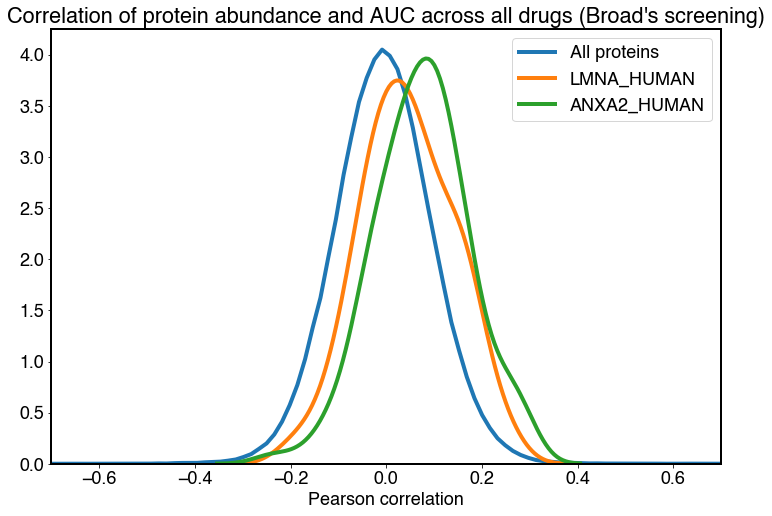

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
plt.title("Correlation of protein abundance and AUC across all drugs (Broad's screening)")
sns.distplot(res_pancancer_all_common['pearson_correlation'], label='All proteins', hist=False, kde_kws=dict(linewidth=4))
sns.distplot(res_pancancer_all_common[res_pancancer_all_common['protein'] ==
                                      "LMNA_HUMAN"]['pearson_correlation'], label='LMNA_HUMAN', hist=False, kde_kws=dict(linewidth=4))
sns.distplot(res_pancancer_all_common[res_pancancer_all_common['protein'] ==
                                      "ANXA2_HUMAN"]['pearson_correlation'], label='ANXA2_HUMAN', hist=False, kde_kws=dict(linewidth=4))
plt.xlabel("Pearson correlation")
plt.xlim(-0.7, 0.7)

# CCLE protein, sanger drug

In [30]:
sanger_pandcancer_correlation = pickle.load(open("../data/correlation/res_pancancer.pkl", "rb"))

(-0.7, 0.7)

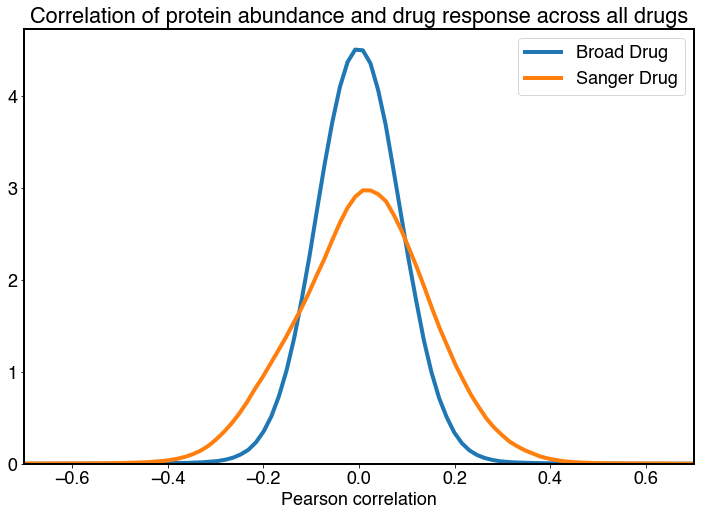

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
plt.title(
    "Correlation of protein abundance and drug response across all drugs"
)
sns.distplot(res_pancancer_all['pearson_correlation'],
             label="Broad Drug",
             hist=False,
             kde_kws=dict(linewidth=4))
sns.distplot(sanger_pandcancer_correlation['pearson_correlation'],
             label='Sanger Drug',
             hist=False,
             kde_kws=dict(linewidth=4))

plt.xlabel("Pearson correlation")
plt.xlim(-0.7, 0.7)

(-0.7, 0.7)

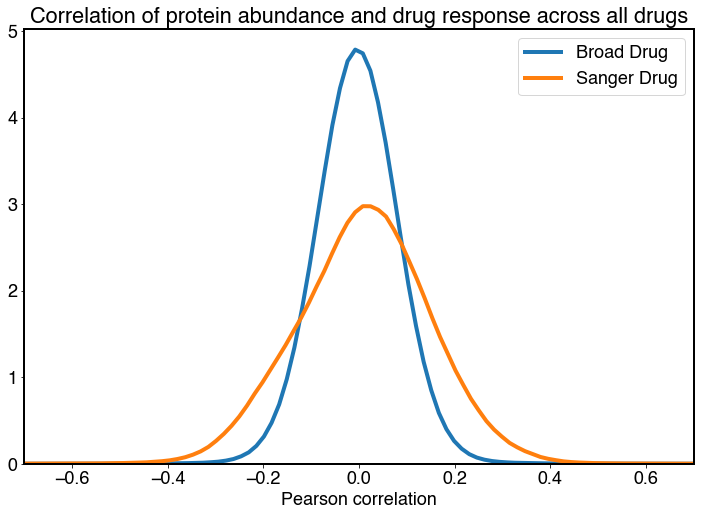

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
plt.title(
    "Correlation of protein abundance and drug response across all drugs"
)
sns.distplot(res_pancancer_all['pearson_correlation'],
             label="Broad Drug",
             hist=False,
             kde_kws=dict(linewidth=4))
sns.distplot(sanger_pandcancer_correlation['pearson_correlation'],
             label='Sanger Drug',
             hist=False,
             kde_kws=dict(linewidth=4))

plt.xlabel("Pearson correlation")
plt.xlim(-0.7, 0.7)

(-0.7, 0.7)

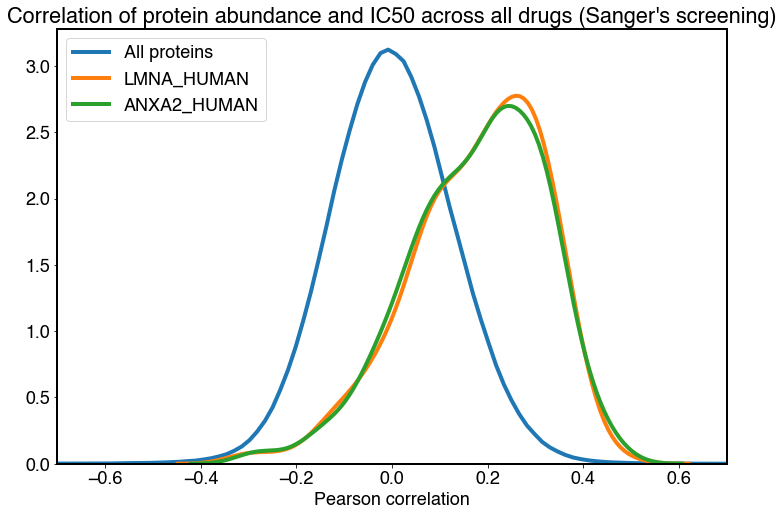

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
plt.title("Correlation of protein abundance and IC50 across all drugs (Sanger's screening)")
sns.distplot(res_pancancer_sanger_drug_all['pearson_correlation'], label='All proteins', hist=False, kde_kws=dict(linewidth=4))
sns.distplot(res_pancancer_sanger_drug_all[res_pancancer_sanger_drug_all['protein'] ==
                                      "LMNA_HUMAN"]['pearson_correlation'], label='LMNA_HUMAN', hist=False, kde_kws=dict(linewidth=4))
sns.distplot(res_pancancer_sanger_drug_all[res_pancancer_sanger_drug_all['protein'] ==
                                      "ANXA2_HUMAN"]['pearson_correlation'], label='ANXA2_HUMAN', hist=False, kde_kws=dict(linewidth=4))
plt.xlabel("Pearson correlation")
plt.xlim(-0.7, 0.7)